In [2]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/GitHub/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.stats import linregress
from matplotlib.backends.backend_pdf import PdfPages
from projects.ephys.population import to_color
import cv2
import xarray as xr
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline
mpl.rcParams.update({'font.size':10})

In [3]:
%matplotlib inline

In [4]:
train_psth = np.load('/home/niell_lab/Desktop/train_psth1.npy')
test_psth = np.load('/home/niell_lab/Desktop/test_psth1.npy')
good_inds = np.load('/home/niell_lab/Desktop/good_inds.npy')

In [5]:
def get_direction_pref(left, right):
    evok_left = left[1000:1250]
    evok_right = right[1000:1250]
    
    ind = np.argmax([np.max(np.abs(evok_left)), np.max(np.abs(evok_right))])
    pref = ['left','right'][ind]
    nonpref = ('left' if pref=='right' else 'right')
    
    return pref, nonpref
    
def normalize_psth(psth, raw_pref=None, baseline_val=None):
    if raw_pref is None:
        raw_pref = psth.copy()
    if baseline_val is None:
        baseline_val = np.nanmean(psth[0:800].astype(float))
    norm_psth = (psth - baseline_val) / np.nanmax(raw_pref[750:1250].astype(float))
    return norm_psth

In [6]:
norm_train = np.zeros([len(good_inds),2001])
norm_test = np.zeros([len(good_inds),2001])
for i, ind in enumerate(good_inds):
    norm_train[i,:] = normalize_psth(train_psth[ind,:])
    norm_test[i,:] = normalize_psth(test_psth[ind,:])

In [7]:
psth_bins = np.arange(-1,1.001,1/1000)

In [9]:
def calc_latency(psth):
    # use norm PSTH
    ind = np.argmax(psth[1025:1250])+1025 # was 1000:1170
    peakT = psth_bins[ind]
    val = psth[ind]
    return peakT, val

In [10]:
train_peakT = np.zeros(np.size(norm_train,0))
test_peakT = np.zeros(np.size(norm_test,0))
for i in range(np.size(norm_train,0)):
    train_peakT[i], _ = calc_latency(norm_train[i,:])
    test_peakT[i], _ = calc_latency(norm_test[i,:])

In [11]:
# sort peak times
order = np.argsort(train_peakT)

sort_train_psths = norm_train[order,:].copy()
sort_test_psths = norm_test[order,:].copy()

In [12]:
def drop_nan_along(x, axis=1):
    # axis=1 will drop along columns (i.e. any rows with NaNs will be dropped)
    x = x[~np.isnan(x).any(axis=axis)]
    return x

In [14]:
def plot_tempseq(panel, tseq, return_img=False, freev=None):
    tseq = drop_nan_along(tseq, 1)
    panel.set_xlabel('msec')
    panel.set_ylim([np.size(tseq,0),0])
    vmin = -0.75; vmax = 0.75
    if freev is not None:
        vmin = -freev
        vmax = freev
    img = panel.imshow(tseq, cmap='coolwarm', vmin=vmin, vmax=vmax)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    panel.set_aspect(2.8)
    if return_img:
        return img

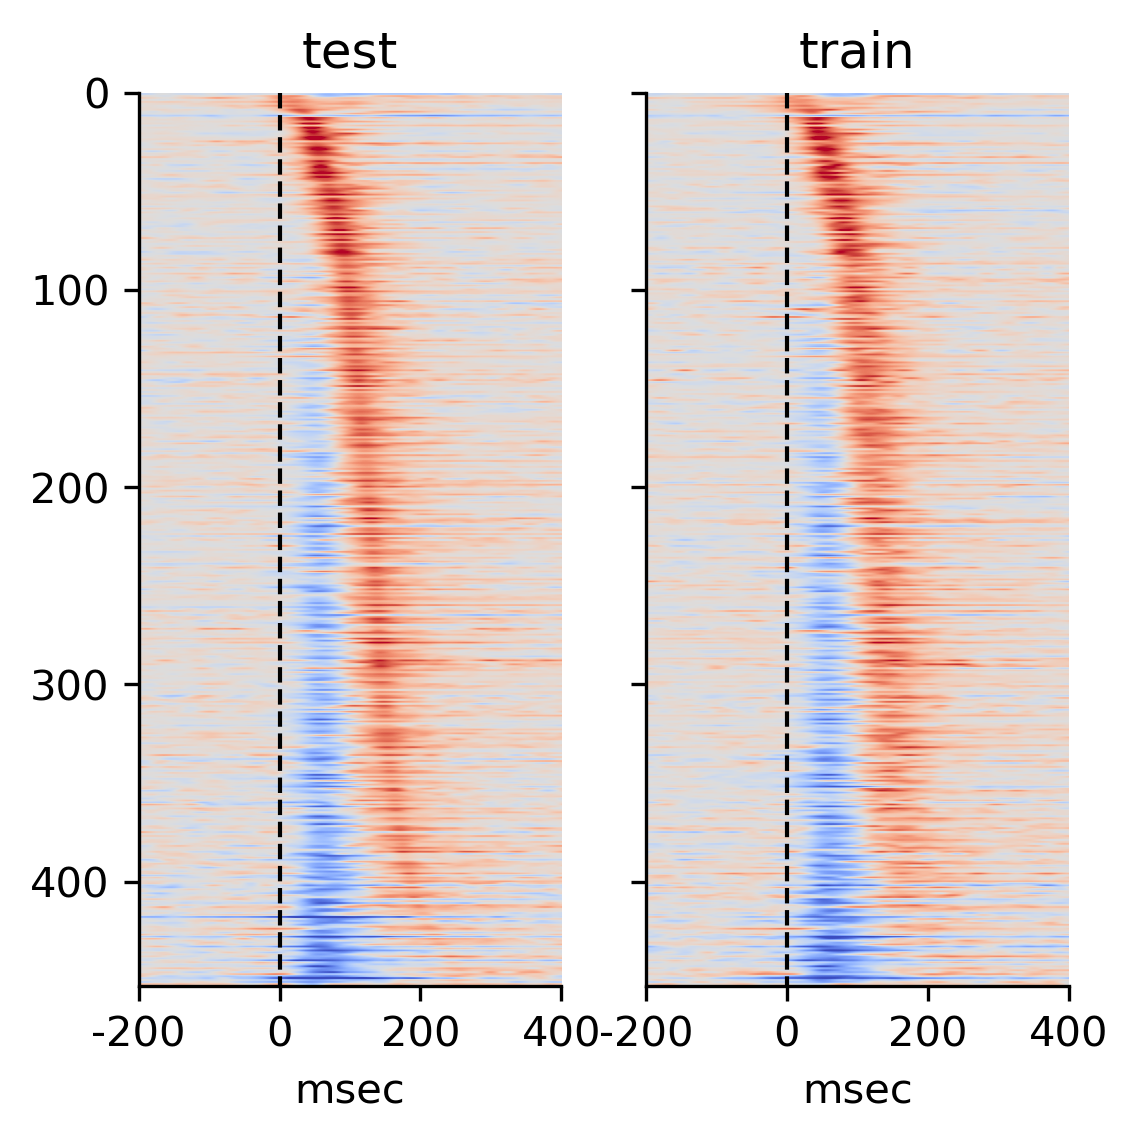

In [15]:
fig, [ax0,ax1] = plt.subplots(1,2,figsize=(4,4), dpi=300)

ax0_img = plot_tempseq(ax0, sort_train_psths)

ax1_img = plot_tempseq(ax1, sort_test_psths)
ax1.set_yticklabels([])

ax0.set_title('test')
ax1.set_title('train')

fig.savefig('/home/niell_lab/Desktop/crossval.pdf')

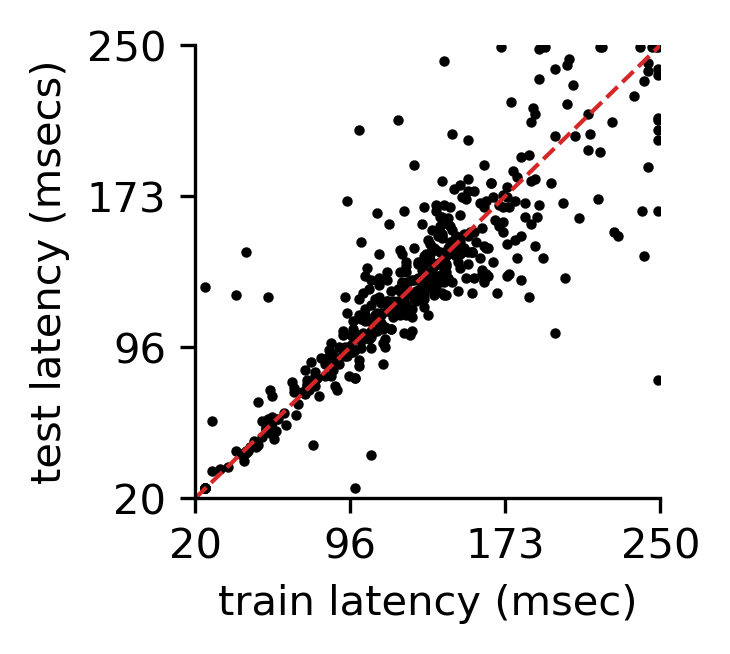

In [19]:
plt.figure(figsize=(2,2), dpi=300)
plt.plot(train_peakT, test_peakT, 'k.', markersize=3)
plt.xlabel('train latency (msec)'); plt.ylabel('test latency (msecs)')
plt.plot([0.02,.250], [0.02,.250], linestyle='dashed', color='tab:red', linewidth=1)
plt.xlim([.020, .25]); plt.ylim([.020, .25])
plt.xticks(np.linspace(0.020,.250,4), labels=np.linspace(20,250,4).astype(int))
plt.yticks(np.linspace(0.020,.250,4), labels=np.linspace(20,250,4).astype(int))

plt.savefig('/home/niell_lab/Desktop/crossval_peakT.pdf', pad_inches=3)

In [20]:
from scipy.stats import linregress

In [21]:
res = linregress(train_peakT, test_peakT)

In [23]:
res.rvalue

0.8578792694126758

In [1]:
0.8578792694126758**2

0.7359568408880264

In [38]:
np.linspace(0.035,.2,4)

array([0.035, 0.09 , 0.145, 0.2  ])

In [34]:
np.linspace(35,200,4).astype(int)

array([ 35,  90, 145, 200])